# GPR-Accelerated NEB Tutorial

This tutorial demonstrates how to use `aenet-gpr` for **GPR-accelerated Nudged Elastic Band (NEB) calculations**, which accelerates the demanding NEB calculations for transition state search.

GPR-NEB references:
- [J. A. Garrido Torres, P. C. Jennings, M. H. Hansen, J. R. Boes, and T. Bligaard, “Low-Scaling Algorithm for Nudged Elastic Band Calculations Using a Surrogate Machine Learning Model”, *Phys. Rev. Lett.* 122, 156001 (2019).](https://doi.org/10.1103/PhysRevLett.122.156001)
- [O. Koistinen, F. B. Dagbjartsdóttir, V. Ásgeirsson, A. Vehtari, and H. Jónsson, "Nudged elastic band calculations accelerated with Gaussian process regression", *J. Chem. Phys.* 147, 152720 (2017)](https://doi.org/10.1063/1.4986787)

In this [NEB example](https://ase-lib.org/tutorials/neb/diffusion.html), we use a simple **EMT potential** as the reference calculator. However, the same framework is fully compatible with any [ASE-compatible DFT calculators](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html).

Replacing the **EMT potential** with a DFT calculator allows GPR-NEB to reproduce **transition states** on a DFT level, with **significantly fewer expensive DFT evaluations** than standard NEB.

# Surface diffusion energy barriers using the Nudged Elastic Band (NEB) method

In [1]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [2]:
try:
    from ase.build import add_adsorbate, fcc100
    from ase.calculators.emt import EMT
    from ase.constraints import FixAtoms
    from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE
    print("You are all set for the tutorial.")
except ImportError:
    print("The notebook needs to be restarted. Run this cell again once the restart is done.")
    import os
    os.kill(os.getpid(), 9)

from IPython.display import Image
import copy
import numpy as np

You are all set for the tutorial.


In [3]:
# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)

In [4]:
# Fix second and third layers:
mask = [atom.tag > 1 for atom in slab]
# print(mask)
slab.set_constraint(FixAtoms(mask=mask))

In [5]:
# Use EMT potential:
slab.calc = EMT()

In [6]:
# Initial state:
qn = BFGS(slab, trajectory='initial.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 17:43:35        3.323870        0.246170
BFGS:    1 17:43:35        3.321365        0.203512
BFGS:    2 17:43:35        3.314740        0.020557


True

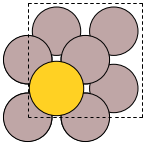

In [7]:
import ase


atoms = ase.io.read('initial.traj')
ase.io.write('initial.png', atoms)
Image("initial.png")

In [8]:
# Final state:
slab[-1].x += slab.get_cell()[0, 0] / 2
qn = BFGS(slab, trajectory='final.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
BFGS:    0 17:43:43        3.320046        0.123468
BFGS:    1 17:43:43        3.319145        0.111073
BFGS:    2 17:43:44        3.315607        0.074162
BFGS:    3 17:43:44        3.315469        0.075507
BFGS:    4 17:43:44        3.314645        0.052638
BFGS:    5 17:43:44        3.314491        0.027698


True

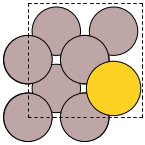

In [9]:
atoms = ase.io.read('final.traj')
ase.io.write('final.png', atoms)
Image("final.png")

## ===== Conventional NEB =====

- Reference calculator: Effective Medium Theory (EMT)

In [10]:
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import read
from ase.mep import NEB

In [11]:
initial = read('initial.traj')
final = read('final.traj')

In [12]:
constraint = FixAtoms(mask=[atom.tag > 1 for atom in initial])

In [13]:
images = [initial]
for i in range(3):
    image = initial.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final)

In [14]:
neb = NEB(images)
neb.interpolate()
qn = FIRE(neb, trajectory='neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy          fmax
FIRE:    0 17:43:44        4.254555        3.670245
FIRE:    1 17:43:44        4.024620        2.636978
FIRE:    2 17:43:44        3.790865        1.233470
FIRE:    3 17:43:44        3.712369        0.247911
FIRE:    4 17:43:44        3.765812        0.737651
FIRE:    5 17:43:45        3.762016        0.718300
FIRE:    6 17:43:45        3.754824        0.679871
FIRE:    7 17:43:45        3.745002        0.622930
FIRE:    8 17:43:45        3.733627        0.548371
FIRE:    9 17:43:45        3.721985        0.457525
FIRE:   10 17:43:45        3.711448        0.352415
FIRE:   11 17:43:45        3.703300        0.236508
FIRE:   12 17:43:45        3.698224        0.165230
FIRE:   13 17:43:45        3.697714        0.196512
FIRE:   14 17:43:45        3.701239        0.351133
FIRE:   15 17:43:45        3.700998        0.345876
FIRE:   16 17:43:45        3.700532        0.335482
FIRE:   17 17:43:45        3.699870        0.320193
FIRE:   18 17:

True

## Total number of reference calculations 

- NEB steps $\times$ number of moving images = 32 $\times$ 3 = 96

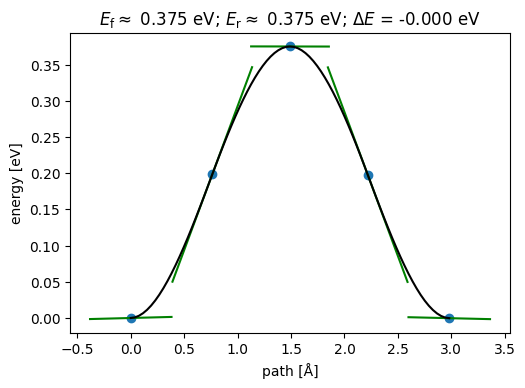

In [15]:
import matplotlib.pyplot as plt

from ase.io import read
from ase.mep import NEBTools

images = read('neb.traj@-5:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')

## ===== aenet-GPR accelerated NEB =====

- Reference calculator: Effective Medium Theory (EMT)
- Surrogate calculator: aenet-gpr (GPR)

In [16]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [17]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 2.1.17
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, dscribe
Required-by: 


In [18]:
from aenet_gpr.tool.aidneb import AIDNEB
from aenet_gpr.inout.input_parameter import InputParameters

In [29]:
neb_interpol = "idpp"  # "linear", "idpp", path to trajectory file
neb_n_images = 5  # total images including initial and final
use_mic = False

In [30]:
initial = read('initial.traj')
final = read('final.traj')

In [31]:
calc = EMT()

In [32]:
input_param = InputParameters()

neb = AIDNEB(start=initial,
             end=final,
             interpolation=neb_interpol,
             n_images=neb_n_images,
             mic=use_mic,
             calculator=copy.deepcopy(calc),
             use_previous_observations=True,
             input_param=input_param)


d_start_end:  2.864235082465442
spring_constant:  0.48757639454002105


In [33]:
neb.run(fmax=0.05, unc_convergence=0.05, ml_steps=150)

Training data size:  3
Descriptor:  cartesian coordinates
Actual training data size (after removing similar data):  3
r_min (threshold to avoid adding nearly-duplicate training data): 0.05
GPR model hyperparameters:  {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(3.4844, dtype=torch.float64)}
      Step     Time          Energy          fmax
FIRE:    0 17:47:43        3.740194        1.713322
FIRE:    1 17:47:43        3.686638        1.710883
FIRE:    2 17:47:44        3.680178        1.644371
FIRE:    3 17:47:45        3.669702        1.408528
FIRE:    4 17:47:46        3.654431        1.005402
FIRE:    5 17:47:46        3.633345        0.456540
FIRE:    6 17:47:48        3.604342        0.448847
FIRE:    7 17:47:49        3.568362        0.453071
FIRE:    8 17:47:50        3.567495        0.448352
FIRE

## Total number of reference calculations 

- Normal NEB: NEB steps $\times$ number of moving images = 32 $\times$ 3 = 96
- GPR-NEB: Training data $-$ initial and final images = 9 - 2 = 7

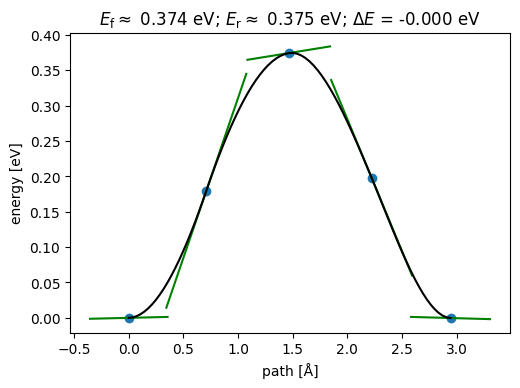

In [34]:
images = read('AIDNEB.traj@-7:')

nebtools = NEBTools(images)

# Create a figure with custom parameters.
fig = plt.figure(figsize=(5.5, 4.0))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.75))
nebtools.plot_band(ax)
fig.savefig('diffusion-barrier.png')